# Predicting Long-Term Mortality: Evidence from Wisconsin Longitudinal Study

### Zejian Lyu

### Problem formation

#### Background:

The current academic literature in predicting mortality has extensively focused on disease and frailty, although social, behavioral, and psychological statuses may herald broad physiological decline. I tested the effectiveness of the machine learning algorithms on the NSHAP sample in Project 1 and learnt the important features predicting mortality. This project will extend the analysis by 1) using a different set of predictors 2) applying some new algorithms in addition to tree-based algorithm 3) using a different dataset.

#### Context:

Wisconsin Longitudinal Study (WLS) is a prospective cohort study of graduates of Wisconsin high schools. I use 2004 characteristics as baseline and 2020 disposition status as target.

#### Goal:

The goal of this project is to train a binary classifier to predict the mortality of US Adults in modern nationally representative aging surveys. I will also discuss the social and demographic characteristics of the cases whose disposition statuses were either wrongly predicted as death or alive by the algorithms. The findings will serve important purposes for public health practitioners in understanding the risk and protective factors of mortality in the aging process.

#### Task:

The task is to train a supervized binary classification model to predict mortality in the next 16 years using the baseline characteristics in 2004.

#### Dataset Links:

<a href= https://researchers.wls.wisc.edu/data/survey-data/>WLS Dataset</a>




#### List of features I will be using:
1. Body mass index: HRS: HC139 - weight in pounds (continuous)
2. Hypertension: HRS: HC005 (binary)
3. Diabetes: HRS: HC010 (binary)
4. Self-rated health: HRS: HC001 (ordinal)
5. Arthritis: HRS: HC070 (binary)
6. Smoking: HRS: HC117 (binary)
7. Drunk alcohol: HRS: HC128 (binary)
8. Age at baseline: HRS: HX067_R (ordinal, year of birth)
9. Education: HRS: HB014A (ordinal)
10. Net household assets: HRS: HC134 + HQ331 + HQ376 (continuous)
11. Marital status: HRS: HMARITAL (binary)
12. Sex: HRS: HX060_R (binary)
13. Race: HRS: HB031A (binary)
14. Religion Importance:  HRS: HB053 (ordinal)
15. Children co-residence: HRS: HE012 (binary)
16. Grandchildren: HRS: HE046 (binary)
17. Relatives: HRS: HF174 (ordinal)
18. Volunteer: HRS: HG092 (binary)
19. Friends: HRS: HF176 (ordinal)
20. Functional limitations: HRS: HG001 (binary)

In [112]:
# import necessary packages
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC

warnings.filterwarnings('ignore')
seed = 42

In [16]:
# Read in the data
wls_raw = pd.read_csv('wls.csv', low_memory=False)
# Select the variables of interest
wls_select = wls_raw[['z_livgrad', 'z_ix011rec', 'z_ax341re', 'z_ax342re',
                      'z_ix001rer', 'z_gx360re', 'z_ix013rec', 'z_gu025re',
                      'z_brdxdy', 'z_gb103red', 'z_gp260hec', 'z_gc042re', 'z_sexrsp',
                      'z_ie020re', 'z_il003rer', 'z_gd103kd', 'z_id014cre',
                      'z_iz106rer', 'z_in504rer', 'z_iz023rer', 'z_iv032re'
                      ]]
# Show the first five rows
wls_select.head(n=5)

,z_livgrad,z_ix011rec,z_ax341re,z_ax342re,z_ix001rer,z_gx360re,z_ix013rec,z_gu025re,z_brdxdy,z_gb103red,...,z_gc042re,z_sexrsp,z_ie020re,z_il003rer,z_gd103kd,z_id014cre,z_iz106rer,z_in504rer,z_iz023rer,z_iv032re
0,1,32,1.0,2.0,4,1,2,1,38,19,...,1,1,1,3,2,2,1,5,2,1
1,1,27,2.0,2.0,4,2,2,1,39,20,...,3,1,1,4,2,2,2,6,6,2
2,1,29,1.0,1.0,5,2,2,1,39,12,...,3,1,1,3,1,2,2,1,2,1
3,1,28,NaN,NaN,5,2,1,1,38,14,...,3,1,1,4,2,2,2,4,1,2
4,1,26,NaN,NaN,4,1,2,1,41,12,...,1,1,1,-3,2,2,2,3,-3,-3


### 1. Preprocessing and exploration

First, I checked whether there are missing values in the dataset.
Second, I encode the label value to bool type for further analysis.
Third, I count the distribution of data to check the class-imbalance condition

In [6]:
# Copy the data for preprocessing
wls = wls_select.copy()
# Check the missing values in the target
print("There is {} missing value in the target: disposition status".format(wls_select['z_livgrad'].isnull().sum()))
# Recode the target for easier interpretation
wls['deceased'] = np.where(wls['z_livgrad'] == 1, "Alive", "Deceased")
wls = wls.drop('z_livgrad', axis=1)
# Show the balance of the target
print("There are {} positive cases and {} negative cases in target".format(wls['deceased'].value_counts()[1],
                                                                           wls['deceased'].value_counts()[0]))

There is 0 missing value in the target: disposition status
There are 2384 positive cases and 7565 negative cases in target


I further selected out the continuous and ordinal categorical features,

and drop samples with loss or invalid value,

and rename the columns to more intuitive term,

and check the distribution properties of each value.

In [7]:
# Preprocess continuous/ordinal variables
# Create a list of continuous/ordinal variables
con_col = ['z_ix011rec', 'z_ix001rer', 'z_brdxdy', 'z_gb103red', 'z_gp260hec',
           'z_il003rer', 'z_iz106rer', 'z_in504rer', 'z_iz023rer']
# Create a new dataframe with only continuous/ordinal variables
wls_ord = wls[wls[con_col].notnull()].copy()[con_col]
# Set values of missing ordinal variables initially coded as negative to nan
wls_ord[wls_ord < 0] = np.nan
# Check the number of missing values in original ordinal variables
wls_ord_na = wls_ord.dropna()
print("Fixed {} respondents with missing ordinal variables".format(len(wls_ord) - len(wls_ord_na)))
# Fill the missing values with the mean of the variable
wls_ord.fillna(wls_ord.mean(), inplace=True)
# Convert the continuous variables from text to numeric variables
for col in con_col:
    wls_ord[col] = pd.to_numeric(wls_ord[col])
# Name the columns
wls_ord.columns = ['BMI', 'Self-Rated Health', 'Age', 'Years of Education',
                   'Household Income', 'Religion Importance',
                   'Social with Relatives', 'Volunteering',
                   'Social with Friends']
# Get the summary statistics of the ordinal variables
wls_ord.describe()

Fixed 1605 respondents with missing ordinal variables


,BMI,Self-Rated Health,Age,Years of Education,Household Income,Religion Importance,Social with Relatives,Volunteering,Social with Friends
count,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000,9949.000000
mean,27.874934,4.006127,39.381785,13.774586,64790.547838,3.558197,1.323093,3.830626,3.548445
std,4.849958,0.675229,4.236784,2.403011,79392.196592,1.085866,0.477515,1.689978,3.738867
min,19.000000,1.000000,18.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,25.000000,4.000000,38.000000,12.000000,22272.000000,3.000000,1.000000,3.000000,1.000000
50%,27.000000,4.000000,39.000000,12.000000,46000.000000,4.000000,1.000000,4.000000,3.000000
75%,30.000000,4.000000,39.000000,16.000000,78400.000000,4.000000,2.000000,5.000000,4.000000
max,45.000000,5.000000,60.000000,21.000000,710000.000000,5.000000,3.000000,7.000000,28.000000


Then, I select the binary features, do similar processing to them.

While preprocessing the data, I found that `z_ax341re` and `z_ax342re` has many missing values. This is because the questionnaire was only sent to a portion of the respondents. Because based on the previous analysis on NSHAP, I believe these two features are important, I decided to keep these two features and fill the missing value with mode.

In [8]:
# Preprocess categorical/binary variables
cat_col = ['z_ax341re', 'z_ax342re', 'z_gx360re', 'z_ix013rec', 'z_gu025re',
           'z_gc042re', 'z_gd103kd', 'z_id014cre', 'z_iv032re',
           'z_sexrsp', 'z_ie020re', ]
# Create a new dataframe with only categorical/binary variables
wls_cat = wls[wls[cat_col].notnull()].copy()[cat_col]
# Set values of missing categorical variables initially coded as negative to nan
wls_cat[wls_cat < 0] = np.nan
# Check the number of missing values in original categorical variables
print("Fixed missing on hypertension", wls_cat['z_ax341re'].isnull().sum())
print("Fixed missing on diabetes", wls_cat['z_ax342re'].isnull().sum())
# Fill the missing values with the mode of the variable
wls_cat.fillna(wls_cat.mode().iloc[0], inplace=True)
# Set values of missing categorical variables initially coded as negative to nan
for col in cat_col[:9]:
    wls_cat[col] = np.where(wls_cat[col] == 1, "Yes", "No")
    wls_cat[col] = wls_cat[col].astype('category')
wls_cat['z_sexrsp'] = np.where(wls_cat['z_sexrsp'] == 1, "Male", "Female")
wls_cat['z_ie020re'] = np.where(wls_cat['z_ie020re'] == 1, "White", "Non-White")
# Name the columns
wls_cat.columns = ['Hypertension', 'Diabetes', 'Arthritis', 'Smoking Status',
                   'Drunk Alcohol', 'Martial Status',
                   'Children Coresidence', 'Grandchildren Coresidence',
                   'Functional Limitation',
                   'Sex', 'Race']
wls_cat

Fixed missing on hypertension 4466
Fixed missing on diabetes 4458


,Hypertension,Diabetes,Arthritis,Smoking Status,Drunk Alcohol,Martial Status,Children Coresidence,Grandchildren Coresidence,Functional Limitation,Sex,Race
0,Yes,No,Yes,No,Yes,Yes,No,No,Yes,Male,White
1,No,No,No,No,Yes,No,No,No,No,Male,White
2,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Male,White
3,No,No,No,Yes,Yes,No,No,No,No,Male,White
4,No,No,Yes,No,Yes,Yes,No,No,No,Male,White
...,...,...,...,...,...,...,...,...,...,...,...
9944,No,No,No,No,Yes,Yes,No,No,Yes,Male,White
9945,No,No,No,No,Yes,No,No,No,No,Male,White
9946,Yes,No,No,No,Yes,No,No,No,No,Female,White
9947,Yes,Yes,No,No,Yes,Yes,No,No,No,Male,White


At last, I concatenate all the columns, and convert all the features into numerical form.
For I am using SVM, Fuzzy SVM in following steps, numercial features are easier to deal with.

In [10]:
wls_clean = pd.concat([wls['deceased'], wls_ord, wls_cat], axis=1)

wls_clean['deceased'] = (wls_clean['deceased'] == 'Deceased').astype(int)

wls_clean['Hypertension'] = (wls_clean['Hypertension'] == 'Yes').astype(int)
wls_clean['Diabetes'] = (wls_clean['Diabetes'] == 'Yes').astype(int)
wls_clean['Arthritis'] = (wls_clean['Arthritis'] == 'Yes').astype(int)
wls_clean['Smoking Status'] = (wls_clean['Smoking Status'] == 'Yes').astype(int)
wls_clean['Drunk Alcohol'] = (wls_clean['Drunk Alcohol'] == 'Yes').astype(int)
wls_clean['Martial Status'] = (wls_clean['Martial Status'] == 'Yes').astype(int)
wls_clean['Children Coresidence'] = (wls_clean['Children Coresidence'] == 'Yes').astype(int)
wls_clean['Grandchildren Coresidence'] = (wls_clean['Grandchildren Coresidence'] == 'Yes').astype(int)
wls_clean['Functional Limitation'] = (wls_clean['Functional Limitation'] == 'Yes').astype(int)

wls_clean['Sex'] = (wls_clean['Sex'] == 'Male').astype(int)
wls_clean['Race'] = (wls_clean['Race'] == 'White').astype(int)
wls_clean.head()

,deceased,BMI,Self-Rated Health,Age,Years of Education,Household Income,Religion Importance,Social with Relatives,Volunteering,Social with Friends,...,Diabetes,Arthritis,Smoking Status,Drunk Alcohol,Martial Status,Children Coresidence,Grandchildren Coresidence,Functional Limitation,Sex,Race
0,0,32.0,4.0,38.0,19.0,81784.0,3.000000,1.0,5.0,2.000000,...,0,1,0,1,1,0,0,1,1,1
1,0,27.0,4.0,39.0,20.0,87000.0,4.000000,2.0,6.0,6.000000,...,0,0,0,1,0,0,0,0,1,1
2,0,29.0,5.0,39.0,12.0,85354.0,3.000000,2.0,1.0,2.000000,...,1,0,0,1,0,1,0,1,1,1
3,0,28.0,5.0,38.0,14.0,336604.0,4.000000,2.0,4.0,1.000000,...,0,0,1,1,0,0,0,0,1,1
4,0,26.0,4.0,41.0,12.0,82800.0,3.558197,2.0,3.0,3.548445,...,0,1,0,1,1,0,0,0,1,1


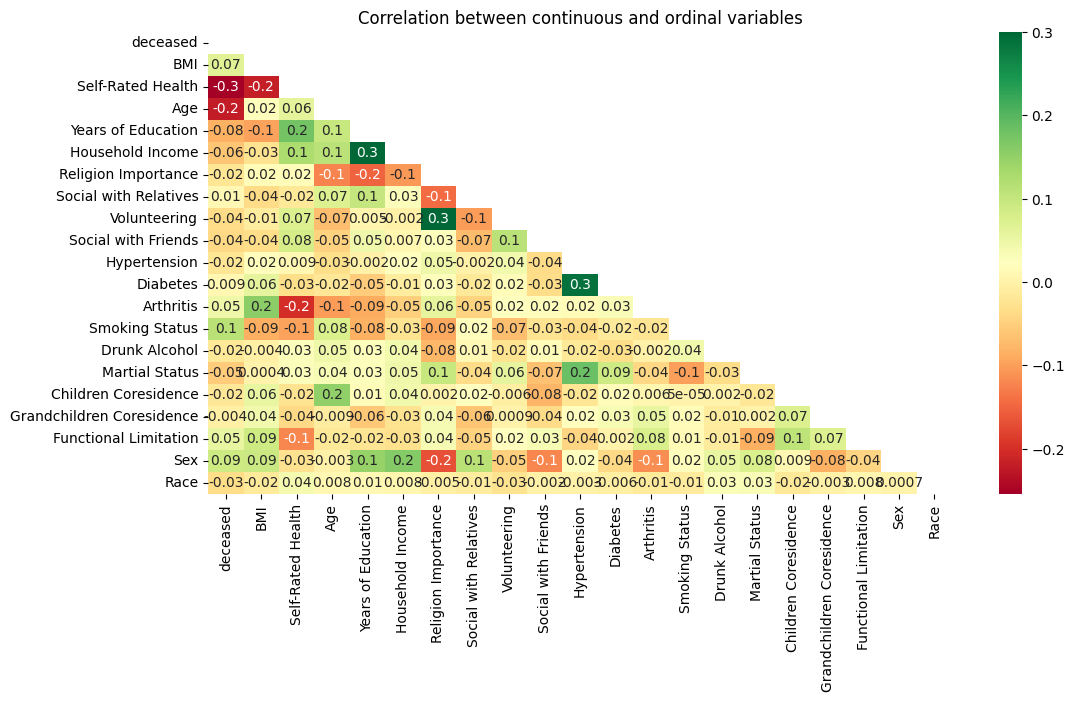

In [113]:
# Analyze the correlation amongst the continuous and ordinal variables
_, ax = plt.subplots(figsize=(12, 6))
# Create a mask to hide the upper triangle of the heatmap
matrix = np.triu(wls_clean.corr())
# Plot the heatmap
sns.heatmap(wls_clean.corr(), annot=True, fmt='.1g', cmap='RdYlGn', ax=ax,
            mask=matrix)
plt.title('Correlation between continuous and ordinal variables')
plt.show()

In [17]:
wls_clean.to_csv('wls_clean.csv', index=False)

### Model training: feature processing, parameter searching and model comparison

Compared to NSHAP, WLS dataset has stronger class imbalance degree. I would like to further address the problem of lacking positive sample.
Different from project 1, I mainly intend to linear and polynomial models.I use logistic regression and SVM classifier to conduct the classification work. And, based on the poor performance 

In [18]:
wls_df = pd.read_csv('wls_clean.csv')

y_df = wls_df[['deceased']]
X_df = wls_df.drop(columns=['deceased'], inplace=False)
X_train_v, X_test, y_train_v, y_test = train_test_split(X_df, y_df,
                                                        test_size=0.2,
                                                        random_state=seed,
                                                        shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v,
                                                  test_size=0.25,
                                                  random_state=seed,
                                                  shuffle=True)

print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)
print("y_train size: ", y_train.shape)
print("y_test size: ", y_test.shape)

X_train size:  (5969, 20)
X_test size:  (1990, 20)
y_train size:  (5969, 1)
y_test size:  (1990, 1)


In [19]:
Con_ftr = ['BMI', 'Self-Rated Health', 'Age', 'Years of Education', 'Household Income', 'Religion Importance',
           'Social with Relatives']
Cat_ftr = ['Hypertension', 'Diabetes', 'Arthritis', 'Smoking Status', 'Drunk Alcohol', 'Martial Status',
           'Children Coresidence', 'Grandchildren Coresidence', 'Functional Limitation', 'Sex', 'Race']
X_train

,BMI,Self-Rated Health,Age,Years of Education,Household Income,Religion Importance,Social with Relatives,Volunteering,Social with Friends,Hypertension,Diabetes,Arthritis,Smoking Status,Drunk Alcohol,Martial Status,Children Coresidence,Grandchildren Coresidence,Functional Limitation,Sex,Race
6590,33.000000,3.0,39.0,12.000000,38600.0,4.000000,1.0,3.0,2.000000,0,0,1,0,1,0,0,0,0,1,1
9722,24.000000,4.0,39.0,16.000000,14712.0,4.000000,1.0,7.0,3.548445,0,0,0,0,0,1,0,0,1,0,1
1362,35.000000,4.0,38.0,12.000000,26016.0,3.558197,1.0,3.0,8.000000,1,0,0,0,1,1,0,0,0,0,1
8856,40.000000,4.0,39.0,12.000000,51816.0,4.000000,1.0,2.0,2.000000,0,0,1,1,1,1,0,0,1,0,1
1521,24.000000,3.0,37.0,13.774586,0.0,4.000000,1.0,1.0,6.000000,0,0,0,0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,29.000000,4.0,29.0,12.000000,27760.0,5.000000,1.0,2.0,1.000000,0,0,1,0,1,0,0,0,0,1,1
905,24.000000,4.0,39.0,18.000000,31600.0,2.000000,2.0,4.0,4.000000,1,0,0,0,1,1,0,0,0,0,1
2663,26.000000,5.0,35.0,20.000000,144900.0,5.000000,1.0,5.0,0.000000,0,0,1,0,0,0,1,1,0,1,1
5919,27.874934,4.0,36.0,15.000000,10908.0,1.000000,1.0,6.0,6.000000,0,0,0,0,1,0,0,0,0,1,1


In [20]:
print("y_train distribution: \n", y_train['deceased'].value_counts())
print("y_test distribution: \n", y_test['deceased'].value_counts())

y_train distribution: 
 0    4520
1    1449
Name: deceased, dtype: int64
y_test distribution: 
 0    1520
1     470
Name: deceased, dtype: int64


## Logistic Regression

In [32]:
# Parameters for the grid search on logistic regression
parameters = [{'penalty': ['l1', 'l2'],
               'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 2, 3, 4, 5, 6, 7, 8]}]
# Evaluation metrics
scores = {"accuracy": "accuracy", "balanced_accuracy": "balanced_accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# Create a dictionary to store the grid search results
records_lr = dict()

# Loop through the evaluation metrics
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    #Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(LogisticRegression(random_state=seed, solver='liblinear',
                                          max_iter=1000),
                       parameters, cv=5, scoring=score, n_jobs=-1)
    #Doing 5-fold cross validation on the training set
    clf.fit(X_train, np.ravel(y_train))
    #Print the best parameters and the corresponding score
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_lr[score] = clf

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(X_val)

    # Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))

    print()

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 3, 'penalty': 'l1'}
Grid scores on development set:

0.757 (+/-0.001) for {'C': 1e-05, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 1e-05, 'penalty': 'l2'}
0.757 (+/-0.001) for {'C': 0.0001, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 0.0001, 'penalty': 'l2'}
0.757 (+/-0.001) for {'C': 0.001, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 0.001, 'penalty': 'l2'}
0.759 (+/-0.004) for {'C': 0.01, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 0.01, 'penalty': 'l2'}
0.775 (+/-0.008) for {'C': 0.1, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 0.1, 'penalty': 'l2'}
0.777 (+/-0.008) for {'C': 1.0, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 1.0, 'penalty': 'l2'}
0.778 (+/-0.009) for {'C': 2, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 2, 'penalty': 'l2'}
0.780 (+/-0.013) for {'C': 3, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 3, 'penalty': 'l2'}
0.780 (+/-0.013) for {'C': 4, 'penalty': 'l1'}
0.757 (+/-0.001) 

In [34]:
# Parameters for the grid search on logistic regression
parameters = [{'penalty': ['l1', 'l2'],
               'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 2, 3, 4, 5, 6, 7, 8]}]
# Evaluation metrics
scores = {"accuracy": "accuracy", "balanced_accuracy": "balanced_accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# Create a dictionary to store the grid search results
records_lr_mmc = dict()
mmc = MinMaxScaler().fit(X_train)

# Loop through the evaluation metrics
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    #Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(LogisticRegression(random_state=seed, solver='liblinear',
                                          max_iter=1000),
                       parameters, cv=5, scoring=score, n_jobs=-1)
    #Doing 5-fold cross validation on the training set
    clf.fit(mmc.transform(X_train), np.ravel(y_train))
    #Print the best parameters and the corresponding score
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_lr_mmc[score] = clf, mmc

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(mmc.transform(X_val))

    # Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))

    print()

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 7, 'penalty': 'l2'}
Grid scores on development set:

0.757 (+/-0.001) for {'C': 1e-05, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 1e-05, 'penalty': 'l2'}
0.757 (+/-0.001) for {'C': 0.0001, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 0.0001, 'penalty': 'l2'}
0.757 (+/-0.001) for {'C': 0.001, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 0.001, 'penalty': 'l2'}
0.757 (+/-0.001) for {'C': 0.01, 'penalty': 'l1'}
0.758 (+/-0.001) for {'C': 0.01, 'penalty': 'l2'}
0.776 (+/-0.010) for {'C': 0.1, 'penalty': 'l1'}
0.769 (+/-0.009) for {'C': 0.1, 'penalty': 'l2'}
0.783 (+/-0.016) for {'C': 1.0, 'penalty': 'l1'}
0.780 (+/-0.014) for {'C': 1.0, 'penalty': 'l2'}
0.783 (+/-0.014) for {'C': 2, 'penalty': 'l1'}
0.782 (+/-0.013) for {'C': 2, 'penalty': 'l2'}
0.783 (+/-0.013) for {'C': 3, 'penalty': 'l1'}
0.783 (+/-0.016) for {'C': 3, 'penalty': 'l2'}
0.783 (+/-0.013) for {'C': 4, 'penalty': 'l1'}
0.783 (+/-0.016) 

In [24]:
poly1 = PolynomialFeatures(interaction_only=True)
X_train_d2 = poly1.fit_transform(X_train)
X_val_d2 = poly1.transform(X_val)

In [26]:
# Parameters for the grid search on logistic regression
parameters = [{'penalty': ['l1', 'l2'],
               'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 2, 3, 4, 5, 6, 7, 8]}]
# Evaluation metrics
scores = {"accuracy": "accuracy", "balanced_accuracy": "balanced_accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# Create a dictionary to store the grid search results
records_kernel_lr = dict()
mmc = MinMaxScaler().fit(X_train_d2)

# Loop through the evaluation metrics
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    #Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(LogisticRegression(random_state=seed, solver='liblinear',
                                          max_iter=1000),
                       parameters, cv=5, scoring=score, n_jobs=-1)
    #Doing 5-fold cross validation on the training set
    clf.fit(mmc.transform(X_train_d2), np.ravel(y_train))
    #Print the best parameters and the corresponding score
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_kernel_lr[score] = clf, mmc

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(mmc.transform(X_val_d2))

    # Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))

    print()

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 1.0, 'penalty': 'l1'}
Grid scores on development set:

0.757 (+/-0.001) for {'C': 1e-05, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 1e-05, 'penalty': 'l2'}
0.757 (+/-0.001) for {'C': 0.0001, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 0.0001, 'penalty': 'l2'}
0.757 (+/-0.001) for {'C': 0.001, 'penalty': 'l1'}
0.757 (+/-0.001) for {'C': 0.001, 'penalty': 'l2'}
0.757 (+/-0.001) for {'C': 0.01, 'penalty': 'l1'}
0.763 (+/-0.006) for {'C': 0.01, 'penalty': 'l2'}
0.777 (+/-0.011) for {'C': 0.1, 'penalty': 'l1'}
0.778 (+/-0.013) for {'C': 0.1, 'penalty': 'l2'}
0.783 (+/-0.015) for {'C': 1.0, 'penalty': 'l1'}
0.783 (+/-0.015) for {'C': 1.0, 'penalty': 'l2'}
0.783 (+/-0.015) for {'C': 2, 'penalty': 'l1'}
0.782 (+/-0.010) for {'C': 2, 'penalty': 'l2'}
0.781 (+/-0.013) for {'C': 3, 'penalty': 'l1'}
0.781 (+/-0.012) for {'C': 3, 'penalty': 'l2'}
0.781 (+/-0.012) for {'C': 4, 'penalty': 'l1'}
0.781 (+/-0.012

## SVM

In [29]:
# Parameters for the grid search on logistic regression
parameters = [{'penalty': ['l1', 'l2'],
               'C': [1e-2, 1e-1, 1, 5, 10, 100],
               'class_weight': [None, 'balanced'],
               }]
# Evaluation metrics
scores = {"accuracy": "accuracy", "balanced_accuracy": "balanced_accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# Create a dictionary to store the grid search results
records_svm = dict()

# Loop through the evaluation metrics
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    #Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(LinearSVC(loss='squared_hinge', random_state=seed),
                       parameters, cv=3, scoring=score, n_jobs=-1)
    #Doing 5-fold cross validation on the training set
    clf.fit(X_train, np.ravel(y_train))
    #Print the best parameters and the corresponding score
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_svm[score] = clf

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(X_val)

    # Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))

    print()

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
Grid scores on development set:

nan (+/-nan) for {'C': 0.01, 'class_weight': None, 'penalty': 'l1'}
0.762 (+/-0.002) for {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}
0.502 (+/-0.364) for {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}
0.748 (+/-0.070) for {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}
0.616 (+/-0.378) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
nan (+/-nan) for {'C': 1, 'class_weight': None, 'penalty': 'l1'}
0.566 (+/-0.388) for {'C': 1, 'class_weight': None, 'penalty': 'l2'}
nan (+/-nan) for {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
0.652 (+/-0.176) for {'C': 1, 'class_weight': 

In [35]:
# Parameters for the grid search on logistic regression
parameters = [{'penalty': ['l1', 'l2'],
               'C': [1e-2, 1e-1, 1, 5, 10, 100],
               'class_weight': [None, 'balanced'],
               }]
# Evaluation metrics
scores = {"accuracy": "accuracy", "balanced_accuracy": "balanced_accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# Create a dictionary to store the grid search results
records_svm_mmc = dict()
mmc = MinMaxScaler().fit(X_train)

# Loop through the evaluation metrics
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    #Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(LinearSVC(loss='squared_hinge', random_state=seed),
                       parameters, cv=3, scoring=score, n_jobs=-1)
    #Doing 5-fold cross validation on the training set
    clf.fit(mmc.transform(X_train), np.ravel(y_train))
    #Print the best parameters and the corresponding score
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_svm_mmc[score] = clf, mmc

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(mmc.transform(X_val))

    # Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))

    print()

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 5, 'class_weight': None, 'penalty': 'l2'}
Grid scores on development set:

nan (+/-nan) for {'C': 0.01, 'class_weight': None, 'penalty': 'l1'}
0.764 (+/-0.004) for {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}
0.672 (+/-0.007) for {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}
0.778 (+/-0.006) for {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}
0.685 (+/-0.011) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
nan (+/-nan) for {'C': 1, 'class_weight': None, 'penalty': 'l1'}
0.779 (+/-0.010) for {'C': 1, 'class_weight': None, 'penalty': 'l2'}
nan (+/-nan) for {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
0.681 (+/-0.017) for {'C': 1, 'class_weight': 'ba

In [31]:
parameters = [{'penalty': ['l1', 'l2'],
               'C': [1e-2, 1e-1, 1, 5, 10, 100],
               'class_weight': [None, 'balanced'],
               }]
# Evaluation metrics
scores = {"accuracy": "accuracy", "balanced_accuracy": "balanced_accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# Create a dictionary to store the grid search results
records_kernel_svm = dict()
mmc = MinMaxScaler().fit(X_train_d2)

# Loop through the evaluation metrics
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    #Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(LinearSVC(loss='squared_hinge', random_state=seed),
                       parameters, cv=3, scoring=score, n_jobs=-1)
    #Doing 5-fold cross validation on the training set
    clf.fit(mmc.transform(X_train_d2), np.ravel(y_train))
    #Print the best parameters and the corresponding score
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_kernel_svm[score] = clf, mmc

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(mmc.transform(X_val_d2))

    # Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))

    print()

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 1, 'class_weight': None, 'penalty': 'l2'}
Grid scores on development set:

nan (+/-nan) for {'C': 0.01, 'class_weight': None, 'penalty': 'l1'}
0.775 (+/-0.011) for {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}
0.682 (+/-0.011) for {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}
0.780 (+/-0.007) for {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}
0.679 (+/-0.015) for {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
nan (+/-nan) for {'C': 1, 'class_weight': None, 'penalty': 'l1'}
0.781 (+/-0.005) for {'C': 1, 'class_weight': None, 'penalty': 'l2'}
nan (+/-nan) for {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
0.675 (+/-0.023) for {'C': 1, 'class_weight': 'ba

## Fuzzy SVM

In [106]:
import random

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

from scipy.sparse import issparse
from scipy.optimize import minimize
from numpy.random import RandomState
from itertools import product
from scipy.optimize import LinearConstraint

In [107]:
class FuzzySVM(BaseEstimator, ClassifierMixin):

    def __init__(self, C=1, kernel='linear', degree=3, coef0=0, gamma=1,
                 max_samples=100, tol=None, max_iter=10, random_state=None, disp=False):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.max_samples = max_samples
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.disp = disp

        self.kernel_fun = self._get_kernel_fun_by_name(kernel)
        self.rs = RandomState(random_state)

        self.alphas = None
        self.X = None
        self.y = None
        self.b = None

    def fit(self, X, ys):
        y = ys
        s = [random.random() for y in ys]

        # replaces 0 labels with -1
        y = y.flatten()
        y = np.copy(y)
        y[y == 0] = -1

        # convert to dense array
        if issparse(X):
            X = X.A

        # sample data
        X, y = self._sample_xy(X, y)

        # minimization
        initial_alphas = np.repeat(0, X.shape[0])
        alphas_bounds = [(0, s[i] * self.C) for i in range(X.shape[0])]
        constraint1 = LinearConstraint(y, 0, 0)
        res = minimize(
            self._loss,
            initial_alphas,
            method='trust-constr',
            args=(X, y, self.kernel_fun),
            bounds=alphas_bounds,
            constraints=(constraint1,),
            tol=self.tol,
            options={'maxiter': self.max_iter, 'disp': self.disp}
        )
        alphas = res.x.ravel()

        # save results
        self.alphas = alphas
        self.X = X
        self.y = y
        self.b = self._calc_bias(alphas, y, X, self.kernel_fun)

        return self

    def _sample_xy(self, X, y):
        n_samples = min(X.shape[0], self.max_samples)
        sampled_X, _, sampled_y, _ = train_test_split(
            X, y,
            train_size=n_samples,
            stratify=y,
            random_state=self.rs
        )
        return sampled_X, sampled_y

    @staticmethod
    def _loss(v, X, ys, kernel_fun):
        alphas = v.flatten()
        n = alphas.size

        s = 0
        for i, j in product(range(n), range(n)):
            s += alphas[i] * alphas[j] * ys[i] * ys[j] * kernel_fun(X[i], X[j])
        return 0.5 * s - np.sum(alphas)

    @staticmethod
    def _calc_bias(alphas, ys, xs, kernel):
        n = xs.shape[0]
        outer_sum = 0
        for i in range(n):
            inner_sum_parts_generator = (alphas[j] * ys[j] * kernel(xs[i], xs[j]) for j in range(n))
            inner_sum = sum(inner_sum_parts_generator)
            outer_sum_part = ys[i] - inner_sum
            outer_sum += outer_sum_part
        return outer_sum / n

    def _get_kernel_fun_by_name(self, kernel_name):
        if kernel_name == 'linear':
            return self._kernel_linear
        elif kernel_name == 'poly':
            return self._kernel_poly
        elif kernel_name == 'rbf':
            return self._kernel_rbf

    def _kernel_linear(self, a, b):
        return a @ b

    def _kernel_poly(self, a, b):
        return (a @ b + self.coef0) ** self.degree

    def _kernel_rbf(self, a, b):
        diff = a - b
        magnitude = np.sqrt(diff @ diff)
        return np.exp(-self.gamma * magnitude)

    def decision_function(self, X):
        n = self.X.shape[0]
        kernel_fun = np.vectorize(self.kernel_fun, signature='(n),(n)->()')
        sum_parts = (self.alphas[i] * self.y[i] * kernel_fun(self.X[i], X) for i in range(n))
        sum_value = sum(sum_parts)
        result = sum_value + self.b
        return result.ravel()

    def predict(self, X):
        return self.decision_function(X) > 0

In [51]:
parameters = [{'kernel': ['linear', 'rbf'],
               'C': [1e-4, 0.02, 1, 50, 1000]
               }]
# Evaluation metrics
scores = {"balanced_accuracy": "balanced_accuracy", "roc_auc": "roc_auc"}

# Create a dictionary to store the grid search results
records_fuzzy_svm = dict()

mmc = MinMaxScaler().fit(np.array(X_train))

# Loop through the evaluation metrics
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    #Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(
        FuzzySVM(degree=2, max_samples=100, max_iter=20, coef0=1, tol=1e-20, disp=True), param_grid=parameters,
        scoring=score, n_jobs=-1,
        cv=None)
    #Doing 5-fold cross validation on the training set
    X_train_m, y_train_m = mmc.transform(np.array(X_train)), np.array(y_train)
    clf.fit(X_train_m, y_train_m)
    #Print the best parameters and the corresponding score
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_fuzzy_svm[score] = clf

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    X_val_m, y_val_m = mmc.transform(np.array(X_val)), np.array(y_val)
    y_true, y_pred = y_val_m, clf.predict(X_val_m)

    # Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))


# Tuning hyper-parameters for balanced_accuracy
The maximum number of function evaluations is exceeded.
Number of iterations: 20, function evaluations: 1717, CG iterations: 89, optimality: 2.18e-03, constraint violation: 3.55e-15, execution time: 8.4e+01 s.
Best parameters set found on development set:
{'C': 50, 'kernel': 'rbf'}
Grid scores on development set:

0.500 (+/-0.000) for {'C': 0.0001, 'kernel': 'linear'}
0.500 (+/-0.000) for {'C': 0.0001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.02, 'kernel': 'linear'}
0.500 (+/-0.000) for {'C': 0.02, 'kernel': 'rbf'}
0.543 (+/-0.059) for {'C': 1, 'kernel': 'linear'}
0.548 (+/-0.037) for {'C': 1, 'kernel': 'rbf'}
0.561 (+/-0.057) for {'C': 50, 'kernel': 'linear'}
0.593 (+/-0.076) for {'C': 50, 'kernel': 'rbf'}
0.546 (+/-0.039) for {'C': 1000, 'kernel': 'linear'}
0.576 (+/-0.040) for {'C': 1000, 'kernel': 'rbf'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluati

In [9]:
fuzzy_svm = make_pipeline(
    MinMaxScaler(),
    FuzzySVM(kernel='linear', degree=2, coef0=1, C=50, max_samples=200, max_iter=100, tol=1e-20, disp=True)
)
fuzzy_svm.fit(np.array(X_train), np.array(y_train))
pickle.dump(fuzzy_svm, open('./fuzzy_svm.md', 'wb'))
y_pred = fuzzy_svm.predict(np.array(X_val))
print(classification_report(y_val, y_pred))

The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 20100, CG iterations: 9596, optimality: 6.83e-01, constraint violation: 1.42e-14, execution time: 2e+03 s.
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1525
           1       0.38      0.49      0.43       465

    accuracy                           0.69      1990
   macro avg       0.60      0.62      0.61      1990
weighted avg       0.72      0.69      0.71      1990



In [111]:
fuzzy_svm_rbfm = make_pipeline(
    MinMaxScaler(),
    FuzzySVM(kernel='rbf', degree=2, coef0=1, C=50, max_samples=100, max_iter=100, tol=1e-20, disp=True)
)
fuzzy_svm_rbfm.fit(np.array(X_train), np.array(y_train))
pickle.dump(fuzzy_svm_rbfm, open('./fuzzy_svm_rbfm.md', 'wb'))
y_pred = fuzzy_svm_rbfm.predict(np.array(X_val))
print(classification_report(y_val, y_pred))

The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 6969, CG iterations: 615, optimality: 4.60e-06, constraint violation: 0.00e+00, execution time: 3.8e+02 s.
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1525
           1       0.34      0.12      0.18       465

    accuracy                           0.74      1990
   macro avg       0.56      0.53      0.51      1990
weighted avg       0.68      0.74      0.69      1990



# Evaluation

### LR

In [39]:
clf_lr, mmc = records_lr_mmc['roc_auc']
print('Performence on training set:',
      accuracy_score(y_train, clf_lr.predict(mmc.transform(X_train)))
      )
print('Performence on testing set:',
      accuracy_score(y_test, clf_lr.predict(mmc.transform(X_test)))
      )

Performence on training set: 0.7842184620539454
Performence on testing set: 0.7819095477386935


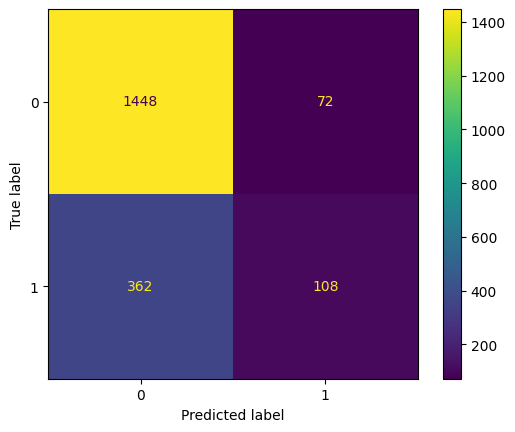

In [42]:
c_mat=confusion_matrix(y_test, clf_lr.predict(mmc.transform(X_test)))
ConfusionMatrixDisplay(confusion_matrix=c_mat).plot()

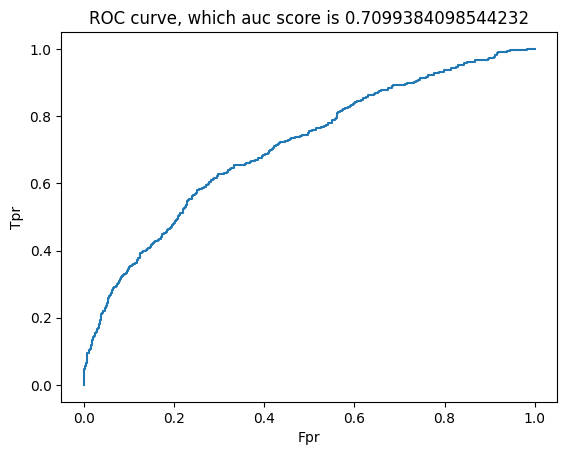

In [46]:
auc=roc_auc_score(y_test,clf_lr.predict_proba(mmc.transform(X_test))[:,1])
curve=roc_curve(y_test,clf_lr.predict_proba(mmc.transform(X_test))[:,1])

plt.title(f"ROC curve, which auc score is {auc}")
plt.plot(curve[0],curve[1])
plt.xlabel("Fpr")
plt.ylabel("Tpr")
plt.show()

In [59]:
pd.DataFrame({
    "feature_name":mmc.feature_names_in_,
    "Coef":list(clf_lr.best_estimator_.coef_)[0]
}).sort_values(by="Coef",key=abs,ascending=False).round(3)

,feature_name,Coef
2,Age,-6.266
1,Self-Rated Health,-3.307
4,Household Income,-0.858
12,Smoking Status,0.720
19,Race,-0.602
18,Sex,0.551
3,Years of Education,-0.422
0,BMI,0.368
5,Religion Importance,-0.325
13,Drunk Alcohol,-0.241


In [80]:
y_pred=clf_lr.predict(mmc.transform(X_test))
X_wrong=X_test.reset_index(inplace=False).drop(columns='index',inplace=False).loc[y_pred!=y_test.reset_index(inplace=False)['deceased']].round(3)
y_wrong=y_test.reset_index(inplace=False).drop(columns='index',inplace=False).loc[y_pred!=y_test.reset_index(inplace=False)['deceased']].round(3)
pd.concat([y_wrong,X_wrong],axis=1).head()

,deceased,BMI,Self-Rated Health,Age,Years of Education,Household Income,Religion Importance,Social with Relatives,Volunteering,Social with Friends,...,Diabetes,Arthritis,Smoking Status,Drunk Alcohol,Martial Status,Children Coresidence,Grandchildren Coresidence,Functional Limitation,Sex,Race
1,1,26.0,5.0,39.0,12.0,67800.0,5.0,1.0,5.0,0.0,...,0,0,1,1,0,0,0,0,0,1
3,1,22.0,4.0,39.0,12.0,32160.0,3.0,2.0,2.0,1.0,...,0,0,0,1,1,0,0,1,1,1
8,1,28.0,4.0,35.0,19.0,52439.0,5.0,1.0,1.0,3.0,...,0,0,0,1,0,0,0,0,1,1
9,0,33.0,4.0,37.0,12.0,30600.0,3.0,1.0,1.0,2.0,...,0,0,1,1,0,0,1,1,1,1
12,1,26.0,4.0,38.0,13.0,40712.0,3.0,1.0,5.0,12.0,...,0,0,0,1,0,0,0,0,1,1


### SVM

In [81]:
clf_svm, mmc = records_svm_mmc['roc_auc']
print('Performence on training set:',
      accuracy_score(y_train, clf_svm.predict(mmc.transform(X_train)))
      )
print('Performence on testing set:',
      accuracy_score(y_test, clf_lr.predict(mmc.transform(X_test)))
      )

Performence on training set: 0.7842184620539454
Performence on testing set: 0.7819095477386935


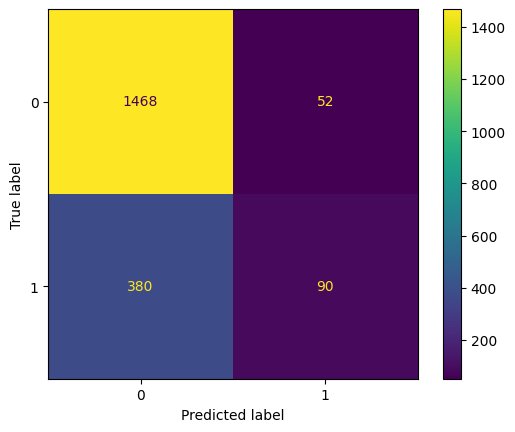

In [84]:
c_mat=confusion_matrix(y_test, clf_svm.predict(mmc.transform(X_test)))
ConfusionMatrixDisplay(confusion_matrix=c_mat).plot()

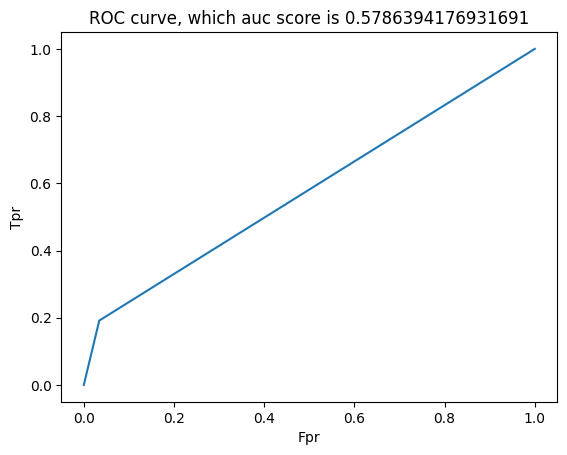

In [87]:
auc=roc_auc_score(y_test,clf_svm.predict(mmc.transform(X_test)))
curve=roc_curve(y_test,clf_svm.predict(mmc.transform(X_test)))

plt.title(f"ROC curve, which auc score is {auc}")
plt.plot(curve[0],curve[1])
plt.xlabel("Fpr")
plt.ylabel("Tpr")
plt.show()

In [89]:
pd.DataFrame({
    "feature_name":mmc.feature_names_in_,
    "Coef":list(clf_svm.best_estimator_.coef_)[0]
}).sort_values(by="Coef",key=abs,ascending=False).round(3)

,feature_name,Coef
2,Age,-2.177
1,Self-Rated Health,-1.184
12,Smoking Status,0.268
4,Household Income,-0.262
19,Race,-0.230
18,Sex,0.183
3,Years of Education,-0.128
5,Religion Importance,-0.107
0,BMI,0.096
13,Drunk Alcohol,-0.093


In [90]:
y_pred=clf_svm.predict(mmc.transform(X_test))
X_wrong=X_test.reset_index(inplace=False).drop(columns='index',inplace=False).loc[y_pred!=y_test.reset_index(inplace=False)['deceased']].round(3)
y_wrong=y_test.reset_index(inplace=False).drop(columns='index',inplace=False).loc[y_pred!=y_test.reset_index(inplace=False)['deceased']].round(3)
pd.concat([y_wrong,X_wrong],axis=1).head()

,deceased,BMI,Self-Rated Health,Age,Years of Education,Household Income,Religion Importance,Social with Relatives,Volunteering,Social with Friends,...,Diabetes,Arthritis,Smoking Status,Drunk Alcohol,Martial Status,Children Coresidence,Grandchildren Coresidence,Functional Limitation,Sex,Race
1,1,26.0,5.0,39.0,12.0,67800.0,5.0,1.0,5.0,0.0,...,0,0,1,1,0,0,0,0,0,1
3,1,22.0,4.0,39.0,12.0,32160.0,3.0,2.0,2.0,1.0,...,0,0,0,1,1,0,0,1,1,1
8,1,28.0,4.0,35.0,19.0,52439.0,5.0,1.0,1.0,3.0,...,0,0,0,1,0,0,0,0,1,1
9,0,33.0,4.0,37.0,12.0,30600.0,3.0,1.0,1.0,2.0,...,0,0,1,1,0,0,1,1,1,1
12,1,26.0,4.0,38.0,13.0,40712.0,3.0,1.0,5.0,12.0,...,0,0,0,1,0,0,0,0,1,1


### Fuzzy SVM

In [94]:
fs_new = pickle.load(open('./fuzzy_svm.md', 'rb'))
print('Performence on training set:',
      accuracy_score(y_train, fs_new[1].predict(fs_new[0].transform(np.array(X_train))))
      )
print('Performence on testing set:',
      accuracy_score(y_test, fs_new[1].predict(fs_new[0].transform(np.array(X_test))))
      )

Performence on training set: 0.694923772826269
Performence on testing set: 0.6658291457286433


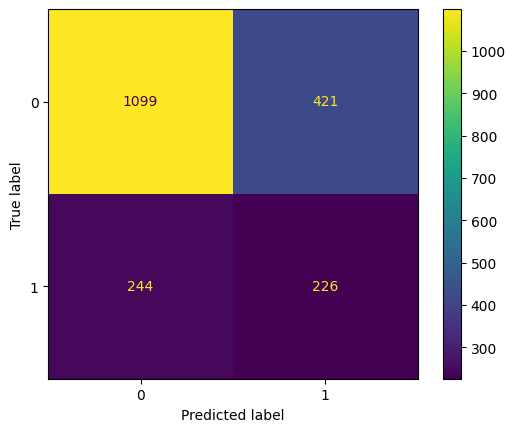

In [95]:
c_mat=confusion_matrix(y_test,fs_new[1].predict(fs_new[0].transform(np.array(X_test))))
ConfusionMatrixDisplay(confusion_matrix=c_mat).plot()

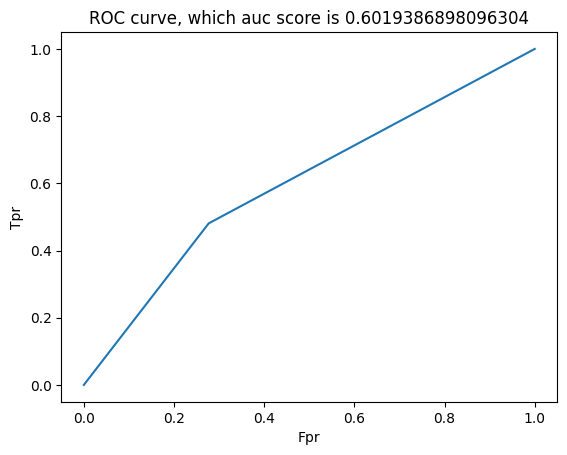

In [97]:
auc = roc_auc_score(y_test, fs_new[1].predict(fs_new[0].transform(np.array(X_test))))
curve = roc_curve(y_test, fs_new[1].predict(fs_new[0].transform(np.array(X_test))))

plt.title(f"ROC curve, which auc score is {auc}")
plt.plot(curve[0], curve[1])
plt.xlabel("Fpr")
plt.ylabel("Tpr")
plt.show()

In [105]:
y_pred=fs_new[1].predict(fs_new[0].transform(np.array(X_test)))
X_wrong=X_test.reset_index(inplace=False).drop(columns='index',inplace=False).loc[y_pred!=y_test.reset_index(inplace=False)['deceased']].round(3)
y_wrong=y_test.reset_index(inplace=False).drop(columns='index',inplace=False).loc[y_pred!=y_test.reset_index(inplace=False)['deceased']].round(3)
pd.concat([y_wrong,X_wrong],axis=1).head(15)

,deceased,BMI,Self-Rated Health,Age,Years of Education,Household Income,Religion Importance,Social with Relatives,Volunteering,Social with Friends,...,Diabetes,Arthritis,Smoking Status,Drunk Alcohol,Martial Status,Children Coresidence,Grandchildren Coresidence,Functional Limitation,Sex,Race
6,0,32.0,4.0,39.0,14.0,69764.0,4.0,1.000,7.0,3.000,...,0,0,0,1,1,0,0,0,1,1
9,0,33.0,4.0,37.0,12.0,30600.0,3.0,1.000,1.0,2.000,...,0,0,1,1,0,0,1,1,1,1
10,0,26.0,4.0,39.0,12.0,93664.0,3.0,1.000,6.0,2.000,...,0,0,0,1,0,0,0,0,1,1
15,0,26.0,3.0,39.0,12.0,69120.0,5.0,1.000,4.0,2.000,...,0,1,0,1,1,0,0,1,1,1
19,0,28.0,4.0,39.0,16.0,156188.0,2.0,1.000,5.0,4.000,...,0,1,0,1,0,0,0,0,1,1
23,0,30.0,5.0,35.0,18.0,65468.0,3.0,1.000,7.0,1.000,...,0,1,0,1,1,0,0,1,1,1
24,0,33.0,4.0,36.0,16.0,68088.0,3.0,1.323,2.0,3.548,...,0,1,1,1,1,0,1,1,1,1
30,1,34.0,4.0,39.0,12.0,46248.0,5.0,2.000,2.0,3.000,...,1,0,0,0,1,0,0,0,0,1
31,1,37.0,4.0,50.0,16.0,92500.0,4.0,1.000,2.0,0.000,...,0,1,0,1,0,0,0,1,1,1
33,0,27.0,2.0,38.0,15.0,0.0,3.0,2.000,2.0,1.000,...,0,1,0,1,1,0,0,0,1,1
